In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_rows',None)
#pd.set_option('display.max_columns',None)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#from sklearn.feature_selection import SelectKBest
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, plot_importance

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, accuracy_score, roc_auc_score

In [2]:
#data_train = pd.read_csv('application_train.csv')
#data_test = pd.read_csv('application_test.csv')

from google.colab import drive
drive.mount('/content/drive')
data_train = pd.read_csv('/content/drive/MyDrive/application_train.csv')
data_test = pd.read_csv('/content/drive/MyDrive/application_test.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
data_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
data_train.shape

(307511, 122)

In [5]:
data_test.shape

(48744, 121)

## Exploration Data Analysis

In [6]:
data_train.duplicated().sum()

0

In [7]:
data_test.duplicated().sum()

0

In [8]:
missval=data_train.isnull().sum()*100/data_train.shape[0]
missval[missval>0].sort_values(ascending=False)

COMMONAREA_AVG                  69.872297
COMMONAREA_MEDI                 69.872297
COMMONAREA_MODE                 69.872297
NONLIVINGAPARTMENTS_AVG         69.432963
NONLIVINGAPARTMENTS_MODE        69.432963
NONLIVINGAPARTMENTS_MEDI        69.432963
FONDKAPREMONT_MODE              68.386172
LIVINGAPARTMENTS_MODE           68.354953
LIVINGAPARTMENTS_MEDI           68.354953
LIVINGAPARTMENTS_AVG            68.354953
FLOORSMIN_MEDI                  67.848630
FLOORSMIN_MODE                  67.848630
FLOORSMIN_AVG                   67.848630
YEARS_BUILD_AVG                 66.497784
YEARS_BUILD_MEDI                66.497784
YEARS_BUILD_MODE                66.497784
OWN_CAR_AGE                     65.990810
LANDAREA_MEDI                   59.376738
LANDAREA_AVG                    59.376738
LANDAREA_MODE                   59.376738
BASEMENTAREA_AVG                58.515956
BASEMENTAREA_MODE               58.515956
BASEMENTAREA_MEDI               58.515956
EXT_SOURCE_1                    56

In [9]:
high_missval=pd.Series(missval[missval>50])
#high_missval.sort_values(ascending=False)

In [10]:
col_to_drop=high_missval.index.to_list()
col_to_drop

['OWN_CAR_AGE',
 'EXT_SOURCE_1',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BUILD_AVG',
 'COMMONAREA_AVG',
 'ELEVATORS_AVG',
 'ENTRANCES_AVG',
 'FLOORSMIN_AVG',
 'LANDAREA_AVG',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAREA_AVG',
 'NONLIVINGAPARTMENTS_AVG',
 'NONLIVINGAREA_AVG',
 'APARTMENTS_MODE',
 'BASEMENTAREA_MODE',
 'YEARS_BUILD_MODE',
 'COMMONAREA_MODE',
 'ELEVATORS_MODE',
 'ENTRANCES_MODE',
 'FLOORSMIN_MODE',
 'LANDAREA_MODE',
 'LIVINGAPARTMENTS_MODE',
 'LIVINGAREA_MODE',
 'NONLIVINGAPARTMENTS_MODE',
 'NONLIVINGAREA_MODE',
 'APARTMENTS_MEDI',
 'BASEMENTAREA_MEDI',
 'YEARS_BUILD_MEDI',
 'COMMONAREA_MEDI',
 'ELEVATORS_MEDI',
 'ENTRANCES_MEDI',
 'FLOORSMIN_MEDI',
 'LANDAREA_MEDI',
 'LIVINGAPARTMENTS_MEDI',
 'LIVINGAREA_MEDI',
 'NONLIVINGAPARTMENTS_MEDI',
 'NONLIVINGAREA_MEDI',
 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MODE',
 'WALLSMATERIAL_MODE']

In [11]:
data_train.drop(columns=col_to_drop,inplace=True)
data_train.shape

(307511, 81)

In [12]:
data_test.drop(columns=col_to_drop,inplace=True)
data_test.shape

(48744, 80)

In [13]:
data_train.select_dtypes(include='object').nunique()

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
EMERGENCYSTATE_MODE            2
dtype: int64

In [14]:
#data_train['ORGANIZATION_TYPE'].isnull().sum()
data_train['ORGANIZATION_TYPE'].value_counts(dropna=False).sort_values(ascending=False)

ORGANIZATION_TYPE
Business Entity Type 3    67992
XNA                       55374
Self-employed             38412
Other                     16683
Medicine                  11193
Business Entity Type 2    10553
Government                10404
School                     8893
Trade: type 7              7831
Kindergarten               6880
Construction               6721
Business Entity Type 1     5984
Transport: type 4          5398
Trade: type 3              3492
Industry: type 9           3368
Industry: type 3           3278
Security                   3247
Housing                    2958
Industry: type 11          2704
Military                   2634
Bank                       2507
Agriculture                2454
Police                     2341
Transport: type 2          2204
Postal                     2157
Security Ministries        1974
Trade: type 2              1900
Restaurant                 1811
Services                   1575
University                 1327
Industry: type 7      

In [15]:
#data_train.drop(columns='ORGANIZATION_TYPE', inplace=True)

In [16]:
#data_test.drop(columns='ORGANIZATION_TYPE', inplace=True)

In [17]:
data_train.select_dtypes(exclude='object').nunique().sort_values(ascending=False)

SK_ID_CURR                      307511
EXT_SOURCE_2                    119831
DAYS_BIRTH                       17460
DAYS_REGISTRATION                15688
AMT_ANNUITY                      13672
DAYS_EMPLOYED                    12574
DAYS_ID_PUBLISH                   6168
AMT_CREDIT                        5603
TOTALAREA_MODE                    5116
DAYS_LAST_PHONE_CHANGE            3773
AMT_INCOME_TOTAL                  2548
AMT_GOODS_PRICE                   1002
EXT_SOURCE_3                       814
FLOORSMAX_AVG                      403
YEARS_BEGINEXPLUATATION_AVG        285
YEARS_BEGINEXPLUATATION_MEDI       245
YEARS_BEGINEXPLUATATION_MODE       221
REGION_POPULATION_RELATIVE          81
FLOORSMAX_MEDI                      49
OBS_60_CNT_SOCIAL_CIRCLE            33
OBS_30_CNT_SOCIAL_CIRCLE            33
FLOORSMAX_MODE                      25
AMT_REQ_CREDIT_BUREAU_YEAR          25
AMT_REQ_CREDIT_BUREAU_MON           24
HOUR_APPR_PROCESS_START             24
CNT_FAM_MEMBERS          

**Anomalies**

In [18]:
data_train[['DAYS_BIRTH','DAYS_EMPLOYED','DAYS_REGISTRATION','DAYS_ID_PUBLISH','DAYS_LAST_PHONE_CHANGE']].describe()

,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,DAYS_LAST_PHONE_CHANGE
count,307511.000000,307511.000000,307511.000000,307511.000000,307510.000000
mean,-16036.995067,63815.045904,-4986.120328,-2994.202373,-962.858788
std,4363.988632,141275.766519,3522.886321,1509.450419,826.808487
min,-25229.000000,-17912.000000,-24672.000000,-7197.000000,-4292.000000
25%,-19682.000000,-2760.000000,-7479.500000,-4299.000000,-1570.000000
50%,-15750.000000,-1213.000000,-4504.000000,-3254.000000,-757.000000
75%,-12413.000000,-289.000000,-2010.000000,-1720.000000,-274.000000
max,-7489.000000,365243.000000,0.000000,0.000000,0.000000


In [19]:
data_test[['DAYS_BIRTH','DAYS_EMPLOYED','DAYS_REGISTRATION','DAYS_ID_PUBLISH','DAYS_LAST_PHONE_CHANGE']].describe()

,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,DAYS_LAST_PHONE_CHANGE
count,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000
mean,-16068.084605,67485.366322,-4967.652716,-3051.712949,-1077.766228
std,4325.900393,144348.507136,3552.612035,1569.276709,878.920740
min,-25195.000000,-17463.000000,-23722.000000,-6348.000000,-4361.000000
25%,-19637.000000,-2910.000000,-7459.250000,-4448.000000,-1766.250000
50%,-15785.000000,-1293.000000,-4490.000000,-3234.000000,-863.000000
75%,-12496.000000,-296.000000,-1901.000000,-1706.000000,-363.000000
max,-7338.000000,365243.000000,0.000000,0.000000,0.000000


In [20]:
data_train['DAYS_BIRTH']=data_train['DAYS_BIRTH'] / -365

In [21]:
data_test['DAYS_BIRTH']=data_test['DAYS_BIRTH'] / -365

In [22]:
data_train['DAYS_BIRTH'].describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

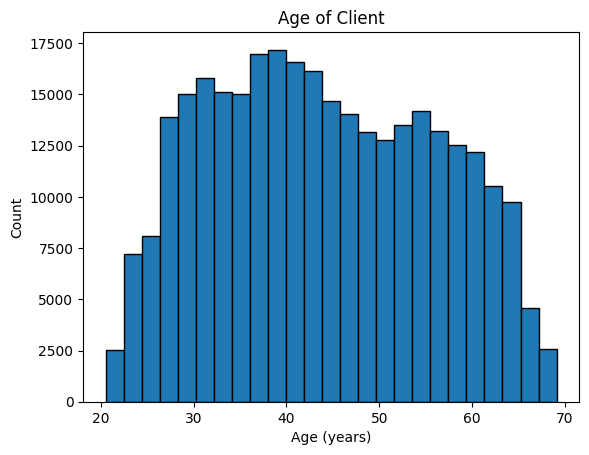

In [23]:
# Set the style of plots
# plt.style.use('fivethirtyeight')

# Plot the distribution of ages in years
plt.hist(data_train['DAYS_BIRTH'], edgecolor = 'k', bins = 25)
plt.title('Age of Client'); plt.xlabel('Age (years)'); plt.ylabel('Count');

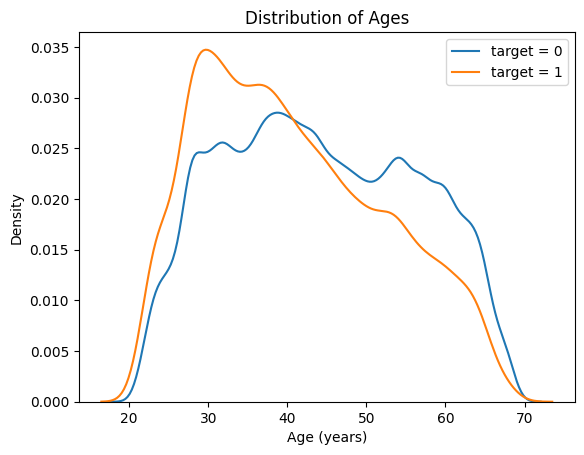

In [24]:
fig=plt.figure()
ax=fig.add_subplot(111)

# KDE plot of loans that were repaid on time
sns.kdeplot(data_train.loc[data_train['TARGET'] == 0, 'DAYS_BIRTH'], label = 'target = 0') #blue

# KDE plot of loans which were not repaid on time
sns.kdeplot(data_train.loc[data_train['TARGET'] == 1, 'DAYS_BIRTH'], label = 'target = 1') #orange

# Labeling of plot
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')

plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages');

In [25]:
data_train['DAYS_EMPLOYED'].isnull().sum()

0

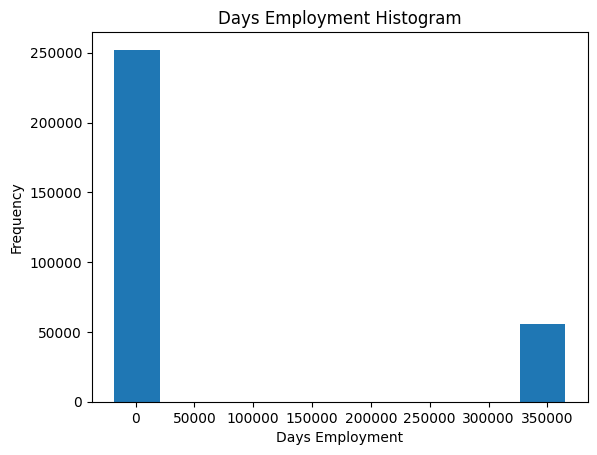

In [26]:
data_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

In [27]:
data_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)
data_test['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

In [28]:
data_train['DAYS_EMPLOYED'].isnull().sum()

55374

In [29]:
data_test['DAYS_EMPLOYED'].isnull().sum()

9274

In [30]:
data_train[['DAYS_EMPLOYED','DAYS_REGISTRATION','DAYS_ID_PUBLISH','DAYS_LAST_PHONE_CHANGE']] = np.where(data_train[['DAYS_EMPLOYED','DAYS_REGISTRATION','DAYS_ID_PUBLISH','DAYS_LAST_PHONE_CHANGE']] < 0, data_train[['DAYS_EMPLOYED','DAYS_REGISTRATION','DAYS_ID_PUBLISH','DAYS_LAST_PHONE_CHANGE']] * -1, data_train[['DAYS_EMPLOYED','DAYS_REGISTRATION','DAYS_ID_PUBLISH','DAYS_LAST_PHONE_CHANGE']])

data_test[['DAYS_EMPLOYED','DAYS_REGISTRATION','DAYS_ID_PUBLISH','DAYS_LAST_PHONE_CHANGE']] = np.where(data_test[['DAYS_EMPLOYED','DAYS_REGISTRATION','DAYS_ID_PUBLISH','DAYS_LAST_PHONE_CHANGE']] < 0, data_test[['DAYS_EMPLOYED','DAYS_REGISTRATION','DAYS_ID_PUBLISH','DAYS_LAST_PHONE_CHANGE']] * -1, data_test[['DAYS_EMPLOYED','DAYS_REGISTRATION','DAYS_ID_PUBLISH','DAYS_LAST_PHONE_CHANGE']])


In [31]:
data_train[['DAYS_BIRTH','DAYS_EMPLOYED','DAYS_REGISTRATION','DAYS_ID_PUBLISH','DAYS_LAST_PHONE_CHANGE']].describe()

,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,DAYS_LAST_PHONE_CHANGE
count,307511.000000,252137.000000,307511.000000,307511.000000,307510.000000
mean,43.936973,2384.169325,4986.120328,2994.202373,962.858788
std,11.956133,2338.360162,3522.886321,1509.450419,826.808487
min,20.517808,0.000000,0.000000,0.000000,0.000000
25%,34.008219,767.000000,2010.000000,1720.000000,274.000000
50%,43.150685,1648.000000,4504.000000,3254.000000,757.000000
75%,53.923288,3175.000000,7479.500000,4299.000000,1570.000000
max,69.120548,17912.000000,24672.000000,7197.000000,4292.000000


In [32]:
data_test[['DAYS_BIRTH','DAYS_EMPLOYED','DAYS_REGISTRATION','DAYS_ID_PUBLISH','DAYS_LAST_PHONE_CHANGE']].describe()

,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,DAYS_LAST_PHONE_CHANGE
count,48744.000000,39470.000000,48744.000000,48744.000000,48744.000000
mean,44.022150,2476.738941,4967.652716,3051.712949,1077.766228
std,11.851782,2307.963913,3552.612035,1569.276709,878.920740
min,20.104110,1.000000,0.000000,0.000000,0.000000
25%,34.235616,861.000000,1901.000000,1706.000000,363.000000
50%,43.246575,1765.000000,4490.000000,3234.000000,863.000000
75%,53.800000,3328.750000,7459.250000,4448.000000,1766.250000
max,69.027397,17463.000000,23722.000000,6348.000000,4361.000000


**Imbalance Label**

TARGET
0    282686
1     24825
Name: count, dtype: int64 TARGET
0    91.927118
1     8.072882
Name: count, dtype: float64


<Axes: ylabel='count'>

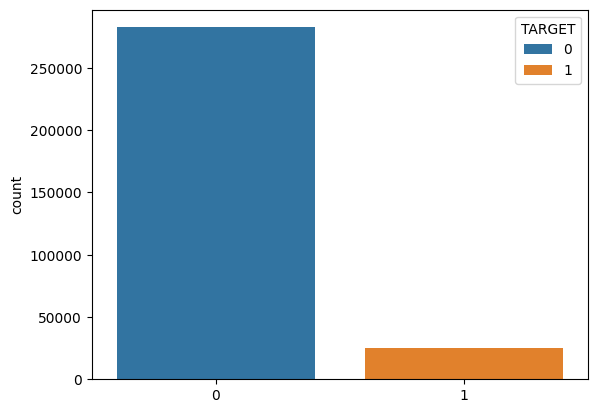

In [33]:
results = (data_train['TARGET'].value_counts() / len(data_train['TARGET']))*100
print(data_train['TARGET'].value_counts(),results)

sns.countplot(x=data_train['TARGET'].values,data=data_train, hue="TARGET")

**Domain Knowledge Features**

CREDIT_INCOME_PERCENT: the percentage of the credit amount relative to a client's income

ANNUITY_INCOME_PERCENT: the percentage of the loan annuity relative to a client's income

CREDIT_TERM: the length of the payment in months (since the annuity is the monthly amount due

DAYS_EMPLOYED_PERCENT: the percentage of the days employed relative to the client's age

In [34]:
app_train_domain = data_train.copy()
app_test_domain = data_test.copy()

app_train_domain['CREDIT_INCOME_PERCENT'] = app_train_domain['AMT_CREDIT'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['ANNUITY_INCOME_PERCENT'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['CREDIT_TERM'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_CREDIT']
app_train_domain['DAYS_EMPLOYED_PERCENT'] = app_train_domain['DAYS_EMPLOYED'] / app_train_domain['DAYS_BIRTH']

In [35]:
app_test_domain['CREDIT_INCOME_PERCENT'] = app_test_domain['AMT_CREDIT'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['ANNUITY_INCOME_PERCENT'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['CREDIT_TERM'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_CREDIT']
app_test_domain['DAYS_EMPLOYED_PERCENT'] = app_test_domain['DAYS_EMPLOYED'] / app_test_domain['DAYS_BIRTH']

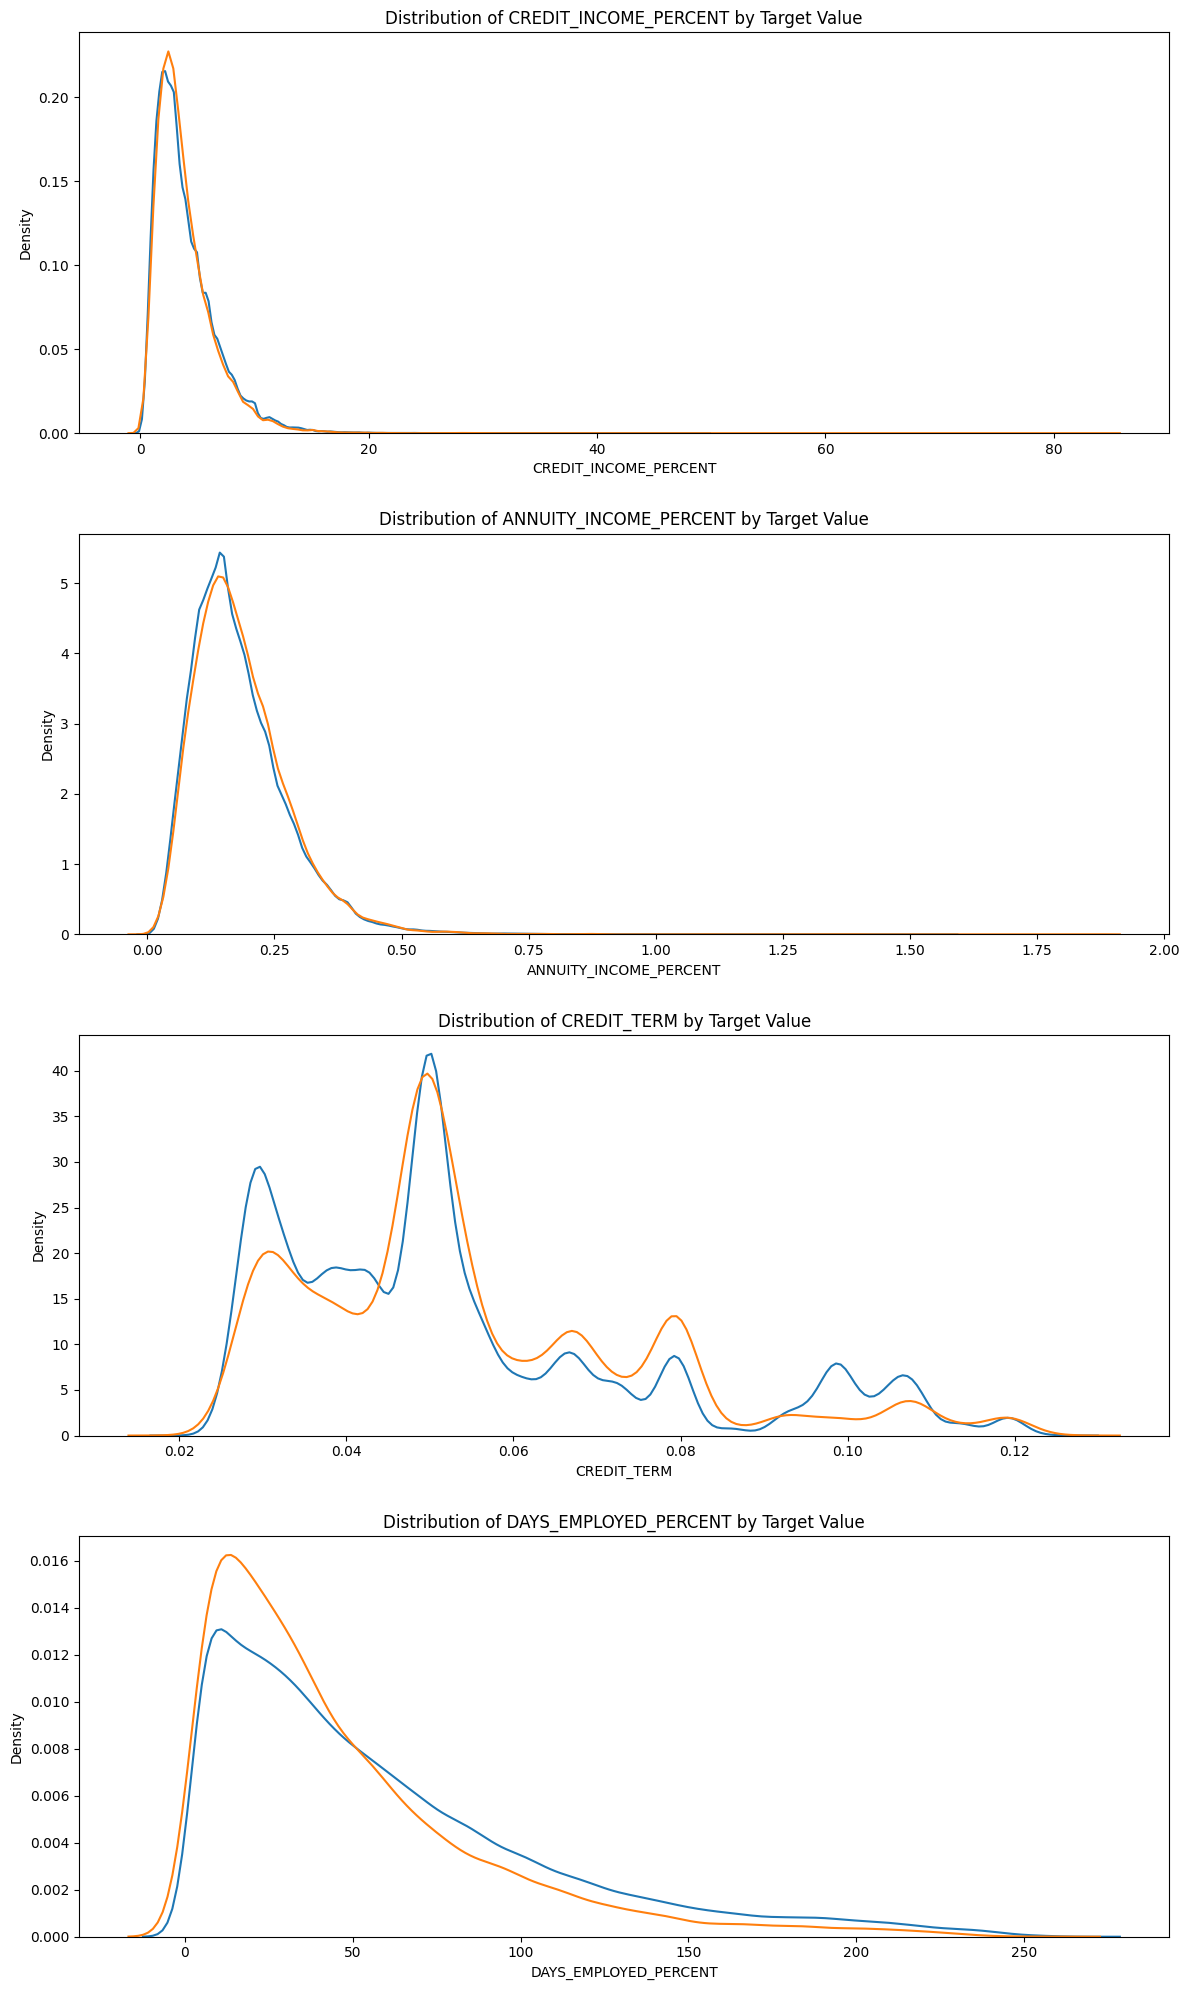

In [36]:
plt.figure(figsize = (12, 20))
# iterate through the new features
for i, feature in enumerate(['CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM', 'DAYS_EMPLOYED_PERCENT']):

    # create a new subplot for each source
    plt.subplot(4, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 0, feature], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 1, feature], label = 'target == 1')

    # Label the plots
    plt.title('Distribution of %s by Target Value' % feature)
    plt.xlabel('%s' % feature); plt.ylabel('Density');

plt.tight_layout(h_pad = 2.5)

## Numerical and Categorical Variables

In [37]:
# list of numerical variables
num = [feature for feature in data_train.columns if data_train[feature].dtypes != 'object' and feature not in ['TARGET','SK_ID_CURR']]

print('Number of numerical variables: ', len(num))

# visualise the numerical variables
data_train[num].head()


Number of numerical variables:  66


,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,0,202500.0,406597.5,24700.5,351000.0,0.018801,25.920548,637.0,3648.0,2120.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,45.931507,1188.0,1186.0,291.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,67500.0,135000.0,6750.0,135000.0,0.010032,52.180822,225.0,4260.0,2531.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,135000.0,312682.5,29686.5,297000.0,0.008019,52.068493,3039.0,9833.0,2437.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,0,121500.0,513000.0,21865.5,513000.0,0.028663,54.608219,3038.0,4311.0,3458.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
# list of categorical variables
kat = [feature for feature in data_train.columns if data_train[feature].dtypes == 'object' and feature not in ['TARGET','SK_ID_CURR']]

print('Number of categorical variables: ', len(kat))

# visualise the categorical variables
data_train[kat].head()


Number of categorical variables:  13


,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,EMERGENCYSTATE_MODE
0,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,WEDNESDAY,Business Entity Type 3,No
1,Cash loans,F,N,N,Family,State servant,Higher education,Married,House / apartment,Core staff,MONDAY,School,No
2,Revolving loans,M,Y,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,MONDAY,Government,NaN
3,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,Laborers,WEDNESDAY,Business Entity Type 3,NaN
4,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Core staff,THURSDAY,Religion,NaN


In [39]:
num_to_kat = [feature for feature in num if data_train[feature].nunique()<=10]

print("Number of num_to_kat : {}".format(len(num_to_kat)))

data_train[num_to_kat].head()

Number of num_to_kat : 39


,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,...,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK
0,1,1,0,1,1,0,2,2,0,0,...,0,0,0,0,0,0,0,0.0,0.0,0.0
1,1,1,0,1,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0.0,0.0,0.0
2,1,1,1,1,1,0,2,2,0,0,...,0,0,0,0,0,0,0,0.0,0.0,0.0
3,1,1,0,1,0,0,2,2,0,0,...,0,0,0,0,0,0,0,NaN,NaN,NaN
4,1,1,0,1,0,0,2,2,0,0,...,0,0,0,0,0,0,0,0.0,0.0,0.0


In [40]:
for col in num_to_kat:
    data_train[col]=data_train[col].astype(str)

data_train[num_to_kat].dtypes

FLAG_MOBIL                     object
FLAG_EMP_PHONE                 object
FLAG_WORK_PHONE                object
FLAG_CONT_MOBILE               object
FLAG_PHONE                     object
FLAG_EMAIL                     object
REGION_RATING_CLIENT           object
REGION_RATING_CLIENT_W_CITY    object
REG_REGION_NOT_LIVE_REGION     object
REG_REGION_NOT_WORK_REGION     object
LIVE_REGION_NOT_WORK_REGION    object
REG_CITY_NOT_LIVE_CITY         object
REG_CITY_NOT_WORK_CITY         object
LIVE_CITY_NOT_WORK_CITY        object
DEF_30_CNT_SOCIAL_CIRCLE       object
DEF_60_CNT_SOCIAL_CIRCLE       object
FLAG_DOCUMENT_2                object
FLAG_DOCUMENT_3                object
FLAG_DOCUMENT_4                object
FLAG_DOCUMENT_5                object
FLAG_DOCUMENT_6                object
FLAG_DOCUMENT_7                object
FLAG_DOCUMENT_8                object
FLAG_DOCUMENT_9                object
FLAG_DOCUMENT_10               object
FLAG_DOCUMENT_11               object
FLAG_DOCUMEN

In [41]:
num_new = [feature for feature in num if feature not in num_to_kat]
print("Number of num_new : {}".format(len(num_new)))

Number of num_new : 27


In [42]:
#kat_new = [feature for feature in kat if feature not in num_to_kat]
#print("Number of kat_new : {}".format(len(kat_new)))

## Outliers

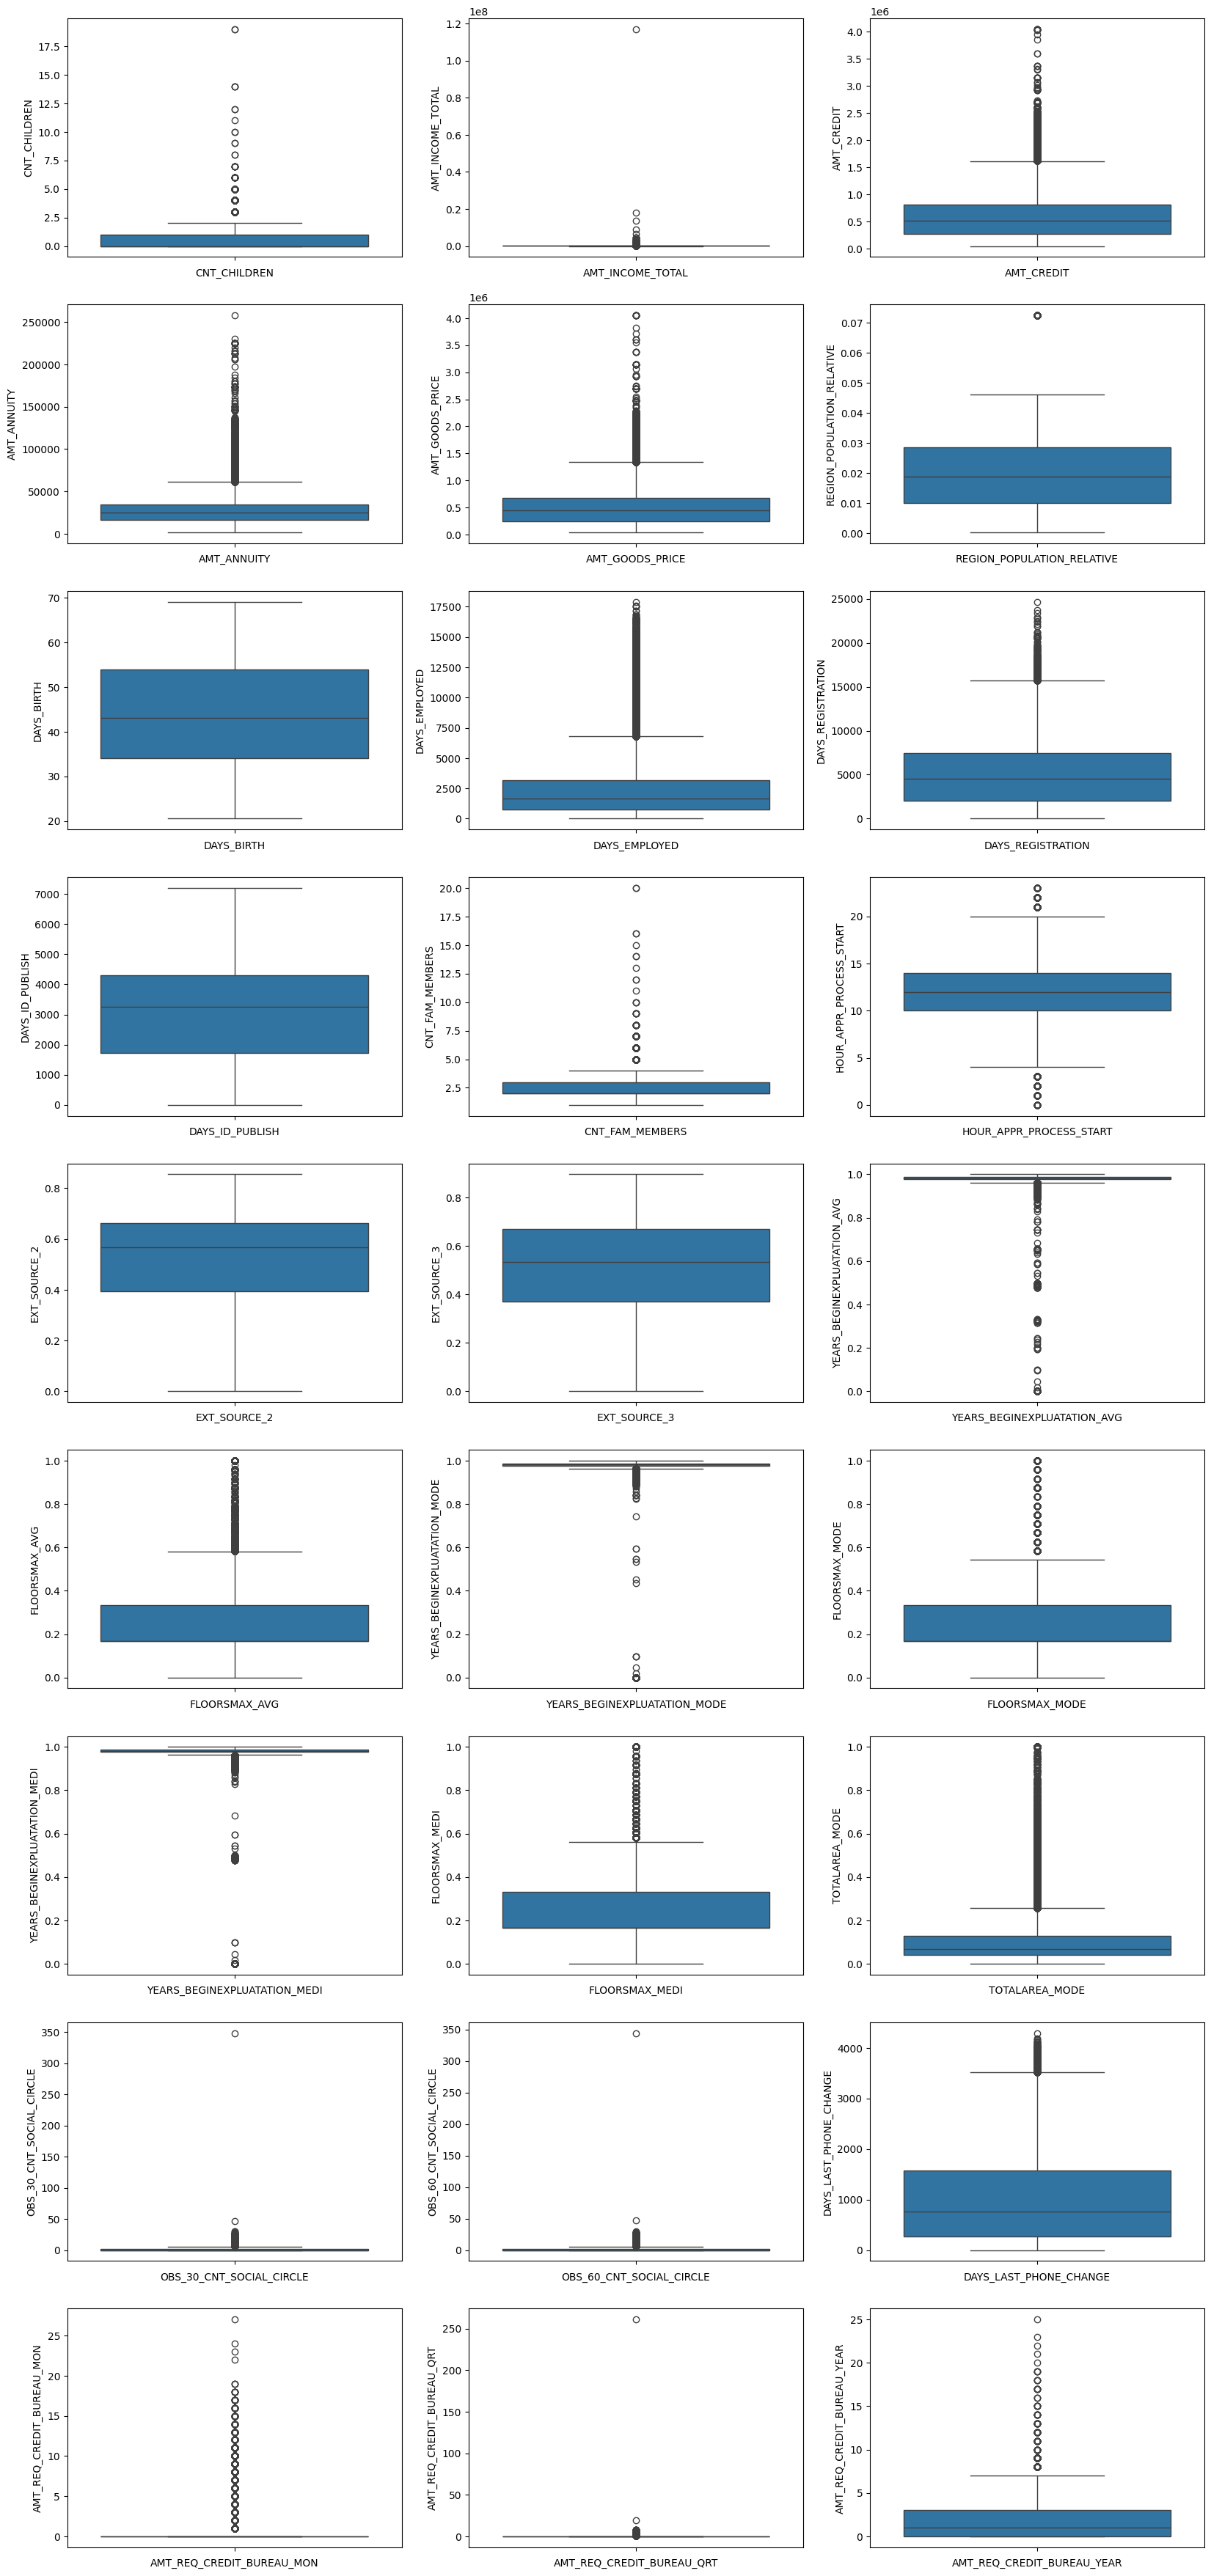

In [43]:
# Before
plt.figure(figsize=(20,60), facecolor='white')
plotnumber =1
for i in num_new:
    ax = plt.subplot(12,3,plotnumber)
    sns.boxplot(data_train[i])
    plt.xlabel(i)
    plotnumber+=1
plt.show()

In [44]:
# Fungsi mendeteksi normal atau skewed
def split_norm_skew_test(data):
    # Membuat data frame dengan nama kolom: feature, skewness, distribution
    global distribution_df
    distribution_df = pd.DataFrame(columns=['feature', 'skewness', 'distribution'])
    for i in range(len(data.columns)):
        if data[data.columns[i]].skew() > -0.5 and data[data.columns[i]].skew() < 0.5:
            distribution_df.loc[i] = [data.columns[i], data[data.columns[i]].skew(), 'normal']
        else:
            distribution_df.loc[i] = [data.columns[i], data[data.columns[i]].skew(), 'skewed']
    print('Membuat tabel "distribution_df"')


# Menjalankan fungsinya
split_norm_skew_test(data_train[num_new])

Membuat tabel "distribution_df"


In [45]:
distribution_df.sort_values(by=['distribution'])

,feature,skewness,distribution
13,EXT_SOURCE_3,-0.409390,normal
6,DAYS_BIRTH,0.115673,normal
9,DAYS_ID_PUBLISH,-0.349327,normal
11,HOUR_APPR_PROCESS_START,-0.028024,normal
24,AMT_REQ_CREDIT_BUREAU_MON,7.804848,skewed
23,DAYS_LAST_PHONE_CHANGE,0.713606,skewed
22,OBS_60_CNT_SOCIAL_CIRCLE,12.070829,skewed
21,OBS_30_CNT_SOCIAL_CIRCLE,12.139598,skewed
20,TOTALAREA_MODE,2.797572,skewed
19,FLOORSMAX_MEDI,1.240185,skewed


In [46]:
# Mendeteksi batasan outlier untuk data berdistribusi normal (Mean ± 1.5*SD)
def outlier_normal(data, jarak):

    global outliers_normal
    outliers_normal = pd.DataFrame(columns=['feature_normal', 'batas atas', 'batas bawah'])

    for i in range(len(data.columns)):

        bawah = data[data.columns[i]].mean() - jarak * data[data.columns[i]].std()
        atas = data[data.columns[i]].mean() + jarak * data[data.columns[i]].std()

        outliers_normal.loc[i] = [data.columns[i], atas, bawah]

    print('Membuat tabel "outliers_normal"')


In [47]:
# Mendeteksi batasan outlier untuk data berdistribusi skewed (Persentil 25 - 1.5*IQR) dan (Persentil 75 + 1.5*IQR)
def outlier_skewed(data, jarak):

    global outliers_skewed
    outliers_skewed = pd.DataFrame(columns=['feature_skewed', 'batas atas', 'batas bawah'])

    for i in range(len(data.columns)):
        # Mendefinisikan IQR
        IQR = data[data.columns[i]].quantile(0.75) - data[data.columns[i]].quantile(0.25)

        # Mendefinisikan batas_bawah dan batas_atas
        bawah = data[data.columns[i]].quantile(0.25) - (IQR * jarak)
        atas = data[data.columns[i]].quantile(0.75) + (IQR * jarak)

        outliers_skewed.loc[i] = [data.columns[i], atas, bawah]

    print('Membuat tabel "outliers_skewed"')


In [48]:
#data_train[['DAYS_BIRTH', 'DAYS_ID_PUBLISH']].head()

In [49]:
#outliers_normal.query("feature_normal=='DAYS_BIRTH'")['batas bawah'].to_list()
#outliers_normal['batas bawah'][0]

In [50]:
list_normal = distribution_df.query("distribution=='normal'")['feature'].to_list()
list_normal

['DAYS_BIRTH', 'DAYS_ID_PUBLISH', 'HOUR_APPR_PROCESS_START', 'EXT_SOURCE_3']

In [51]:
list_skewed = distribution_df.query("distribution=='skewed'")['feature'].to_list()
list_skewed

['CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'CNT_FAM_MEMBERS',
 'EXT_SOURCE_2',
 'YEARS_BEGINEXPLUATATION_AVG',
 'FLOORSMAX_AVG',
 'YEARS_BEGINEXPLUATATION_MODE',
 'FLOORSMAX_MODE',
 'YEARS_BEGINEXPLUATATION_MEDI',
 'FLOORSMAX_MEDI',
 'TOTALAREA_MODE',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'DAYS_LAST_PHONE_CHANGE',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'AMT_REQ_CREDIT_BUREAU_YEAR']

In [52]:
outlier_normal(data_train[list_normal],1.5)

Membuat tabel "outliers_normal"


In [53]:
outliers_normal

,feature_normal,batas atas,batas bawah
0,DAYS_BIRTH,61.871173,26.002773
1,DAYS_ID_PUBLISH,5258.378002,730.026745
2,HOUR_APPR_PROCESS_START,16.962167,7.164670
3,EXT_SOURCE_3,0.803119,0.218586


In [54]:
i=0
for n in list_normal:
    data_train[[n]] = np.where(data_train[[n]] < outliers_normal['batas bawah'][i], outliers_normal['batas bawah'][i],
                           np.where(data_train[[n]] > outliers_normal['batas atas'][i], outliers_normal['batas atas'][i], data_train[[n]]))
    i+=1

#data_train[list_normal].head()


In [55]:
outlier_skewed(data_train[list_skewed],1.5)

Membuat tabel "outliers_skewed"


In [56]:
outliers_skewed

,feature_skewed,batas atas,batas bawah
0,CNT_CHILDREN,2.500000e+00,-1.500000
1,AMT_INCOME_TOTAL,3.375000e+05,-22500.000000
2,AMT_CREDIT,1.616625e+06,-537975.000000
3,AMT_ANNUITY,6.170400e+04,-10584.000000
4,AMT_GOODS_PRICE,1.341000e+06,-423000.000000
5,REGION_POPULATION_RELATIVE,5.664850e-02,-0.017980
6,DAYS_EMPLOYED,6.787000e+03,-2845.000000
7,DAYS_REGISTRATION,1.568375e+04,-6194.250000
8,CNT_FAM_MEMBERS,4.500000e+00,0.500000
9,EXT_SOURCE_2,1.070357e+00,-0.014282


In [57]:
i=0
for n in list_skewed:
    data_train[[n]] = np.where(data_train[[n]] < outliers_skewed['batas bawah'][i], outliers_skewed['batas bawah'][i],
                           np.where(data_train[[n]] > outliers_skewed['batas atas'][i], outliers_skewed['batas atas'][i], data_train[[n]]))
    i+=1

#data_train[list_skewed].head()


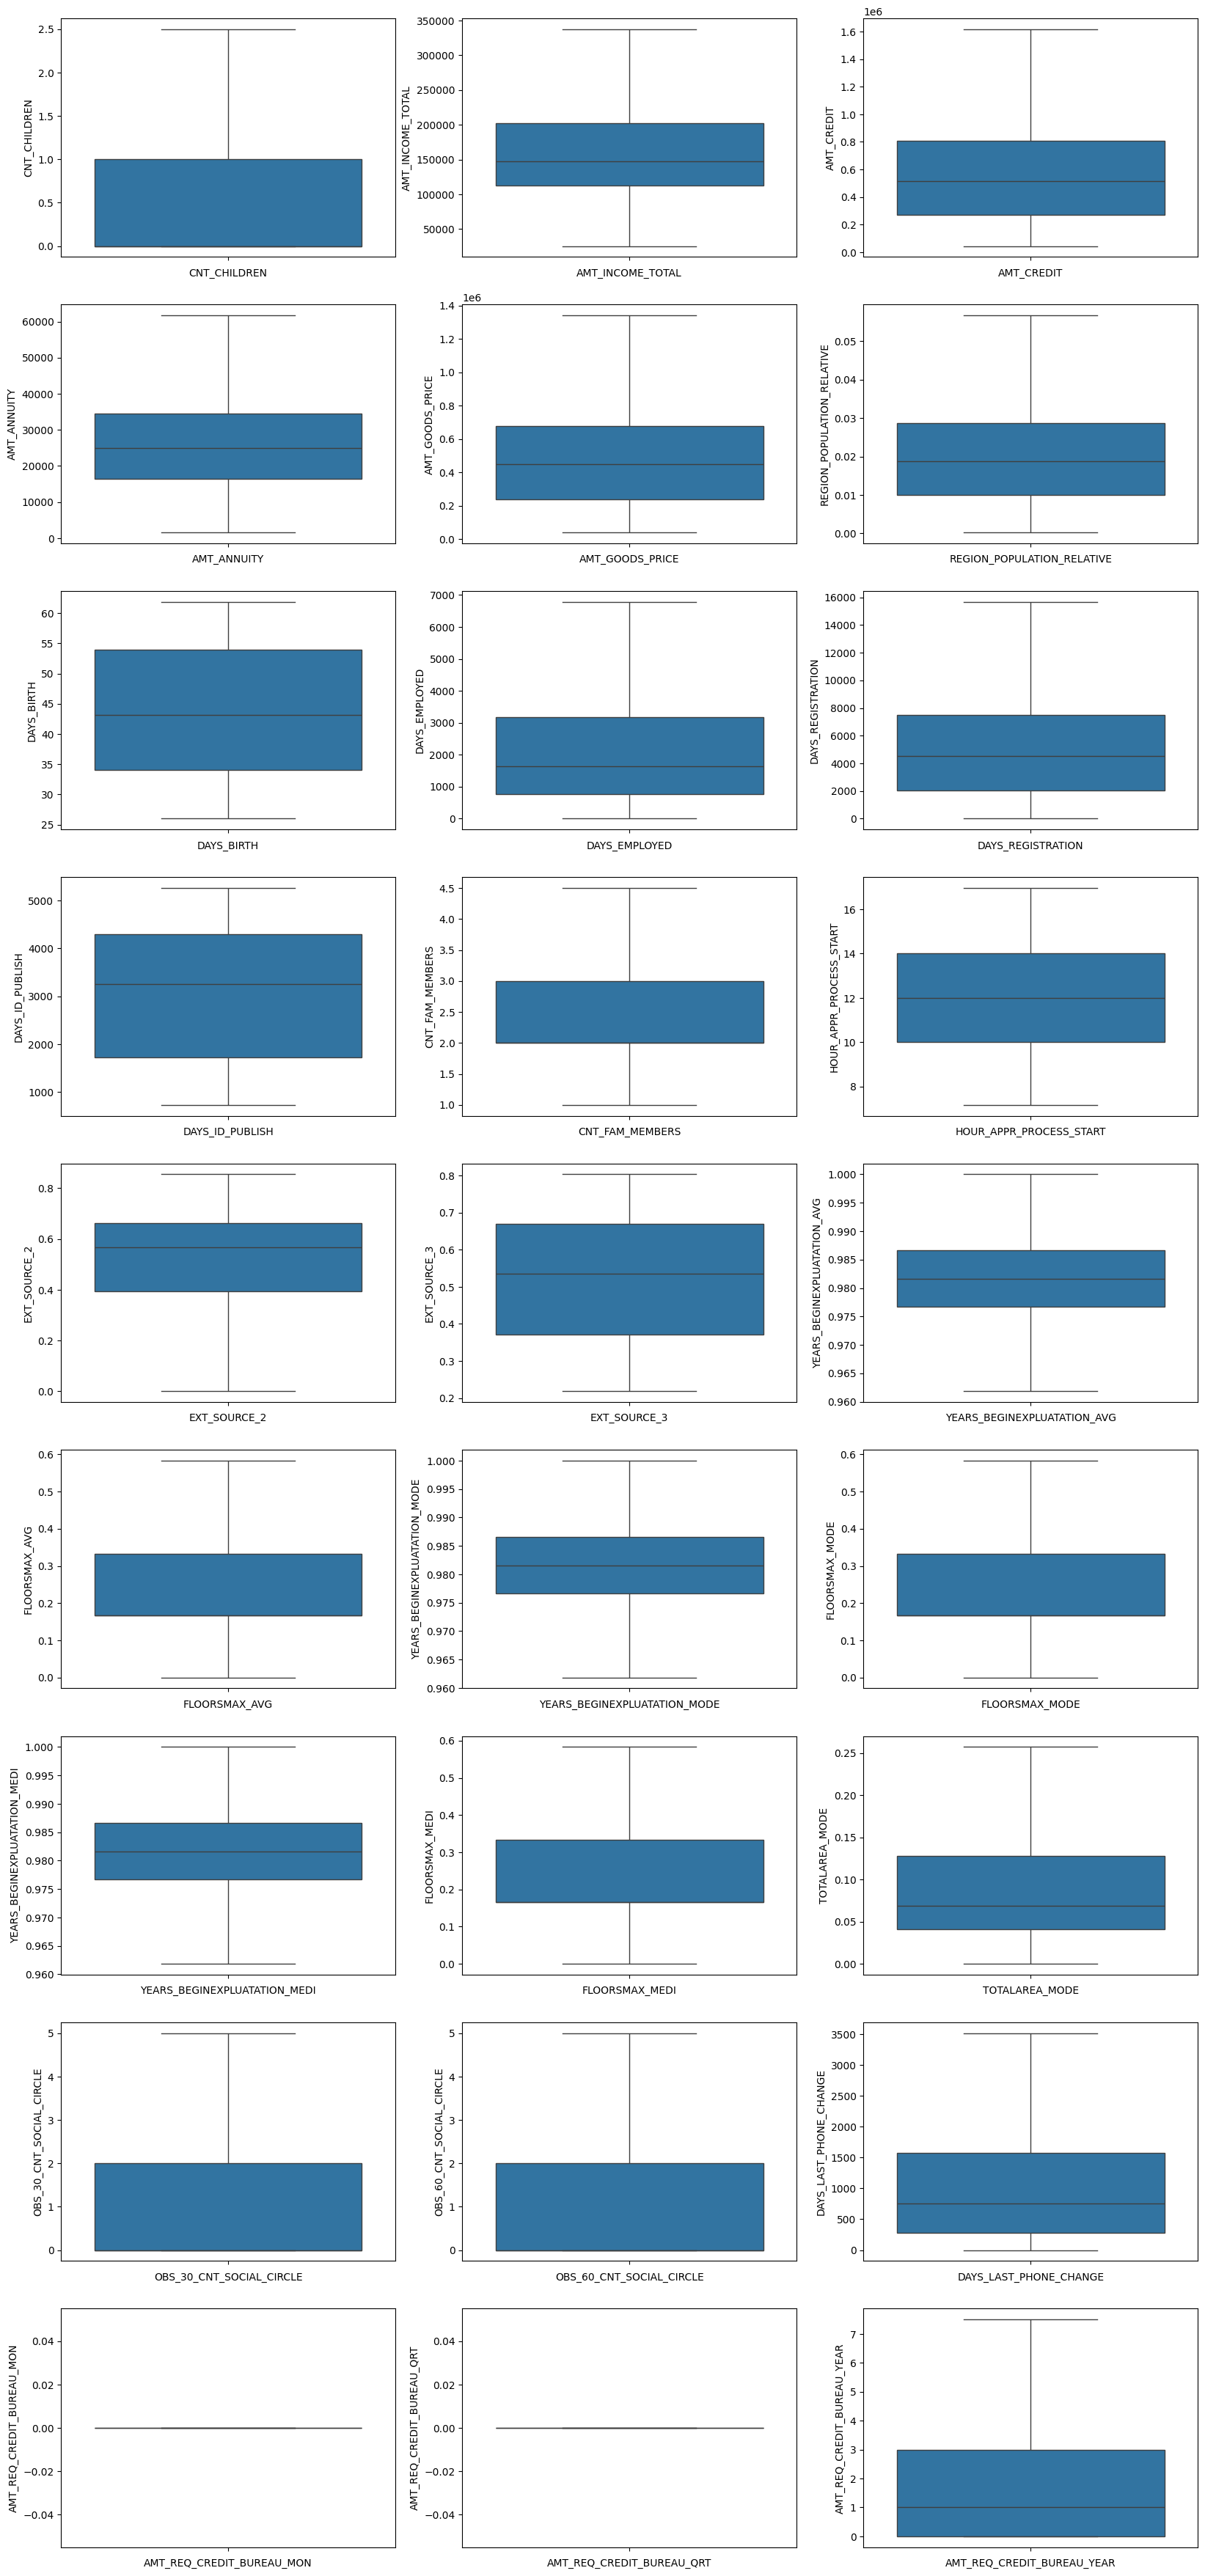

In [58]:
# After
plt.figure(figsize=(20,60), facecolor='white')
plotnumber =1
for i in num_new:
    ax = plt.subplot(12,3,plotnumber)
    sns.boxplot(data_train[i])
    plt.xlabel(i)
    plotnumber+=1
plt.show()

## Pipeline Preprocessing

In [59]:
_train=pd.DataFrame(data_train[['SK_ID_CURR','TARGET']])
_test=pd.DataFrame(data_test[['SK_ID_CURR']])
#_train.head()

In [60]:
not_org = [var for var in kat if var not in ['OCCUPATION_TYPE','ORGANIZATION_TYPE']]
not_org

['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'EMERGENCYSTATE_MODE']

In [61]:
# Membuat Pipeline untuk preprocessing

prenum = Pipeline([
    ('imp', SimpleImputer(strategy='median')),
    ('scl', MinMaxScaler())
])

prekat1 = Pipeline([
    ('imp', SimpleImputer(strategy='constant', fill_value='missing')),
    ('enc', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
])

prekat2 = Pipeline([
    ('imp', SimpleImputer(strategy='median')),
    ('scl', MinMaxScaler())
])

#prekat3 = Pipeline([
#    ('lenc', LabelEncoder())
#])

# Menggabungkan kedua pipeline di atas
preprocessor = ColumnTransformer([
    ('pnum', prenum, num_new),
    ('pkat1', prekat1, not_org),
    ('pkat2', prekat2, num_to_kat)
    #('lenc', prekat3, ['ORGANIZATION_TYPE','OCCUPATION_TYPE'])
])


In [62]:
data_train['ORGANIZATION_TYPE']=LabelEncoder().fit_transform(data_train['ORGANIZATION_TYPE'])
data_test['ORGANIZATION_TYPE']=LabelEncoder().fit_transform(data_test['ORGANIZATION_TYPE'])

data_train['OCCUPATION_TYPE']=LabelEncoder().fit_transform(data_train['OCCUPATION_TYPE'])
data_test['OCCUPATION_TYPE']=LabelEncoder().fit_transform(data_test['OCCUPATION_TYPE'])

In [63]:
preprocessor.fit(data_train)

train_transformed = preprocessor.transform(data_train)

train_features = preprocessor.get_feature_names_out()

In [64]:
preprocessor.fit(data_test)

test_transformed = preprocessor.transform(data_test)

test_features = preprocessor.get_feature_names_out()

In [65]:
data_train[['ORGANIZATION_TYPE','OCCUPATION_TYPE']].head()

,ORGANIZATION_TYPE,OCCUPATION_TYPE
0,5,8
1,39,3
2,11,8
3,5,8
4,37,3


In [66]:
train_new= pd.DataFrame(train_transformed,columns=train_features)
#train_new.head()

In [67]:
test_new= pd.DataFrame(test_transformed,columns=test_features)
#test_new.head()

In [68]:
np.round(train_new.describe(),1)

,pnum__CNT_CHILDREN,pnum__AMT_INCOME_TOTAL,pnum__AMT_CREDIT,pnum__AMT_ANNUITY,pnum__AMT_GOODS_PRICE,pnum__REGION_POPULATION_RELATIVE,pnum__DAYS_BIRTH,pnum__DAYS_EMPLOYED,pnum__DAYS_REGISTRATION,pnum__DAYS_ID_PUBLISH,...,pkat2__FLAG_DOCUMENT_15,pkat2__FLAG_DOCUMENT_16,pkat2__FLAG_DOCUMENT_17,pkat2__FLAG_DOCUMENT_18,pkat2__FLAG_DOCUMENT_19,pkat2__FLAG_DOCUMENT_20,pkat2__FLAG_DOCUMENT_21,pkat2__AMT_REQ_CREDIT_BUREAU_HOUR,pkat2__AMT_REQ_CREDIT_BUREAU_DAY,pkat2__AMT_REQ_CREDIT_BUREAU_WEEK
count,307511.0,307511.0,307511.0,307511.0,307511.0,307511.0,307511.0,307511.0,307511.0,307511.0,...,307511.0,307511.0,307511.0,307511.0,307511.0,307511.0,307511.0,307511.0,307511.0,307511.0
mean,0.2,0.4,0.3,0.4,0.4,0.4,0.5,0.3,0.3,0.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,0.3,0.2,0.2,0.2,0.3,0.2,0.3,0.3,0.2,0.3,...,0.0,0.1,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.3,0.1,0.2,0.2,0.2,0.2,0.1,0.1,0.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.4,0.3,0.4,0.3,0.3,0.5,0.2,0.3,0.6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,0.4,0.6,0.5,0.5,0.5,0.5,0.8,0.4,0.5,0.8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [69]:
#train_new[['SK_ID_CURR','TARGET']].head()
#data_train[['SK_ID_CURR','TARGET']].head()
#test_new['SK_ID_CURR'].head()

In [70]:
datatrain_new = pd.concat([_train, train_new], axis=1)
#datatest_new = pd.concat([_test, test_new], axis=1)

datatrain_new.tail()

,SK_ID_CURR,TARGET,pnum__CNT_CHILDREN,pnum__AMT_INCOME_TOTAL,pnum__AMT_CREDIT,pnum__AMT_ANNUITY,pnum__AMT_GOODS_PRICE,pnum__REGION_POPULATION_RELATIVE,pnum__DAYS_BIRTH,pnum__DAYS_EMPLOYED,...,pkat2__FLAG_DOCUMENT_15,pkat2__FLAG_DOCUMENT_16,pkat2__FLAG_DOCUMENT_17,pkat2__FLAG_DOCUMENT_18,pkat2__FLAG_DOCUMENT_19,pkat2__FLAG_DOCUMENT_20,pkat2__FLAG_DOCUMENT_21,pkat2__AMT_REQ_CREDIT_BUREAU_HOUR,pkat2__AMT_REQ_CREDIT_BUREAU_DAY,pkat2__AMT_REQ_CREDIT_BUREAU_WEEK
307506,456251,0,0.0,0.422799,0.133429,0.431738,0.141869,0.572602,0.000000,0.034772,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
307507,456252,0,0.0,0.148629,0.142878,0.172845,0.141869,0.441353,0.861902,0.242817,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
307508,456253,0,0.0,0.408369,0.402554,0.472029,0.418685,0.083608,0.418194,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0
307509,456254,1,0.0,0.466089,0.206860,0.309369,0.214533,0.089126,0.188664,0.705172,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
307510,456255,0,0.0,0.422799,0.400859,0.790534,0.487889,0.814961,0.562558,0.185944,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0


## Over Sampling

In [71]:
X = datatrain_new.drop(['TARGET','SK_ID_CURR'],axis=1)
y = datatrain_new['TARGET']

In [72]:
#!pip install -U imbalanced-learn

In [73]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(
    sampling_strategy= 'auto', # sampling untuk kategori minoritas
    random_state= 123,  # untuk replikasi
)

# Fitting ke X dan y
X_res, y_res = ros.fit_resample(X,y)

#from imblearn.over_sampling import SMOTE
#smote = SMOTE(random_state=42)
#X_res, y_res= smote.fit_resample(X,y)


<Axes: >

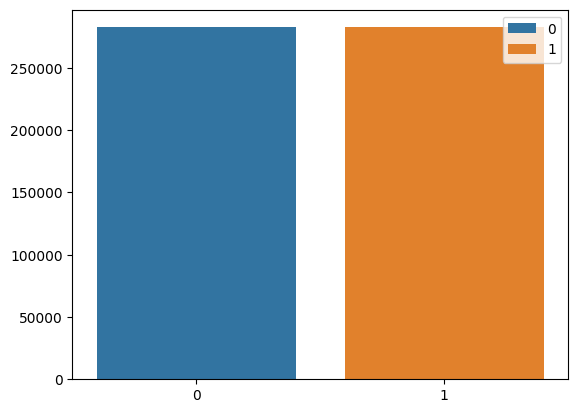

In [74]:
idx, c = np.unique(y_res, return_counts=True)
sns.barplot(x=idx, y=c, hue=idx)

In [75]:
# Splitting data
X_train, X_test, y_train, y_test = train_test_split(
    X_res,
    y_res,
    test_size = 0.2,
    random_state = 42)

# Reset indeks dengan looping
for i in [X_train, X_test, y_train, y_test]:
    i.reset_index(drop=True, inplace=True)

# Melihat dimensi training set dan test set
print(X_train.shape, X_test.shape)

(452297, 107) (113075, 107)


## Feature Selection

In [76]:
# find and remove the correlated features
#def correlation(dataset,threshold):
#    col_corr = set()
#    corr_matrix=dataset.corr()
#    for i in range(len(corr_matrix.columns)):
#        for j in range(i):
#            if abs(corr_matrix.iloc[i,j]>threshold):
#                colname=corr_matrix.columns[i]
#                col_corr.add(colname)
#    return col_corr

In [77]:
#corr_features=correlation(X_train, 0.5)
#len(corr_features)

In [78]:
#X_train.drop(corr_features,axis=1)
#X_test.drop(corr_features,axis=1)

In [79]:
#datatest_new.drop(corr_features,axis=1)

## Modeling

**Logistic Regression**

In [81]:
#from sklearn.linear_model import SGDClassifier
logreg = LogisticRegression(random_state=42, max_iter=1000)

logreg.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [82]:
y_pred = logreg.predict(X_test)

In [83]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.68      0.68      0.68     56536
           1       0.68      0.68      0.68     56539

    accuracy                           0.68    113075
   macro avg       0.68      0.68      0.68    113075
weighted avg       0.68      0.68      0.68    113075



In [84]:
cm_log = confusion_matrix(y_test, y_pred)
#print(cm_log)

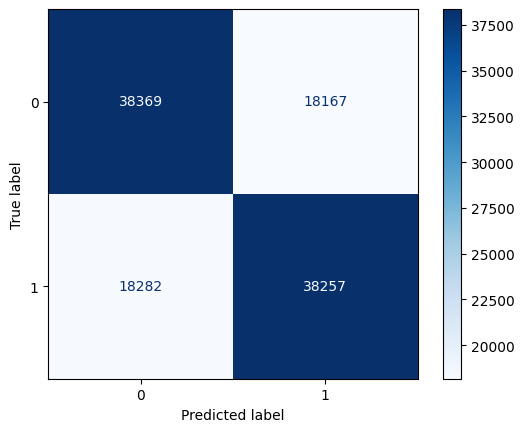

In [85]:
# Melihat confusion matrix dengan ConfusionMatrixDisplay()
vis_cm = ConfusionMatrixDisplay(confusion_matrix = cm_log,
                                display_labels = logreg.classes_)
vis_cm.plot(cmap=plt.cm.Blues);

<Axes: >

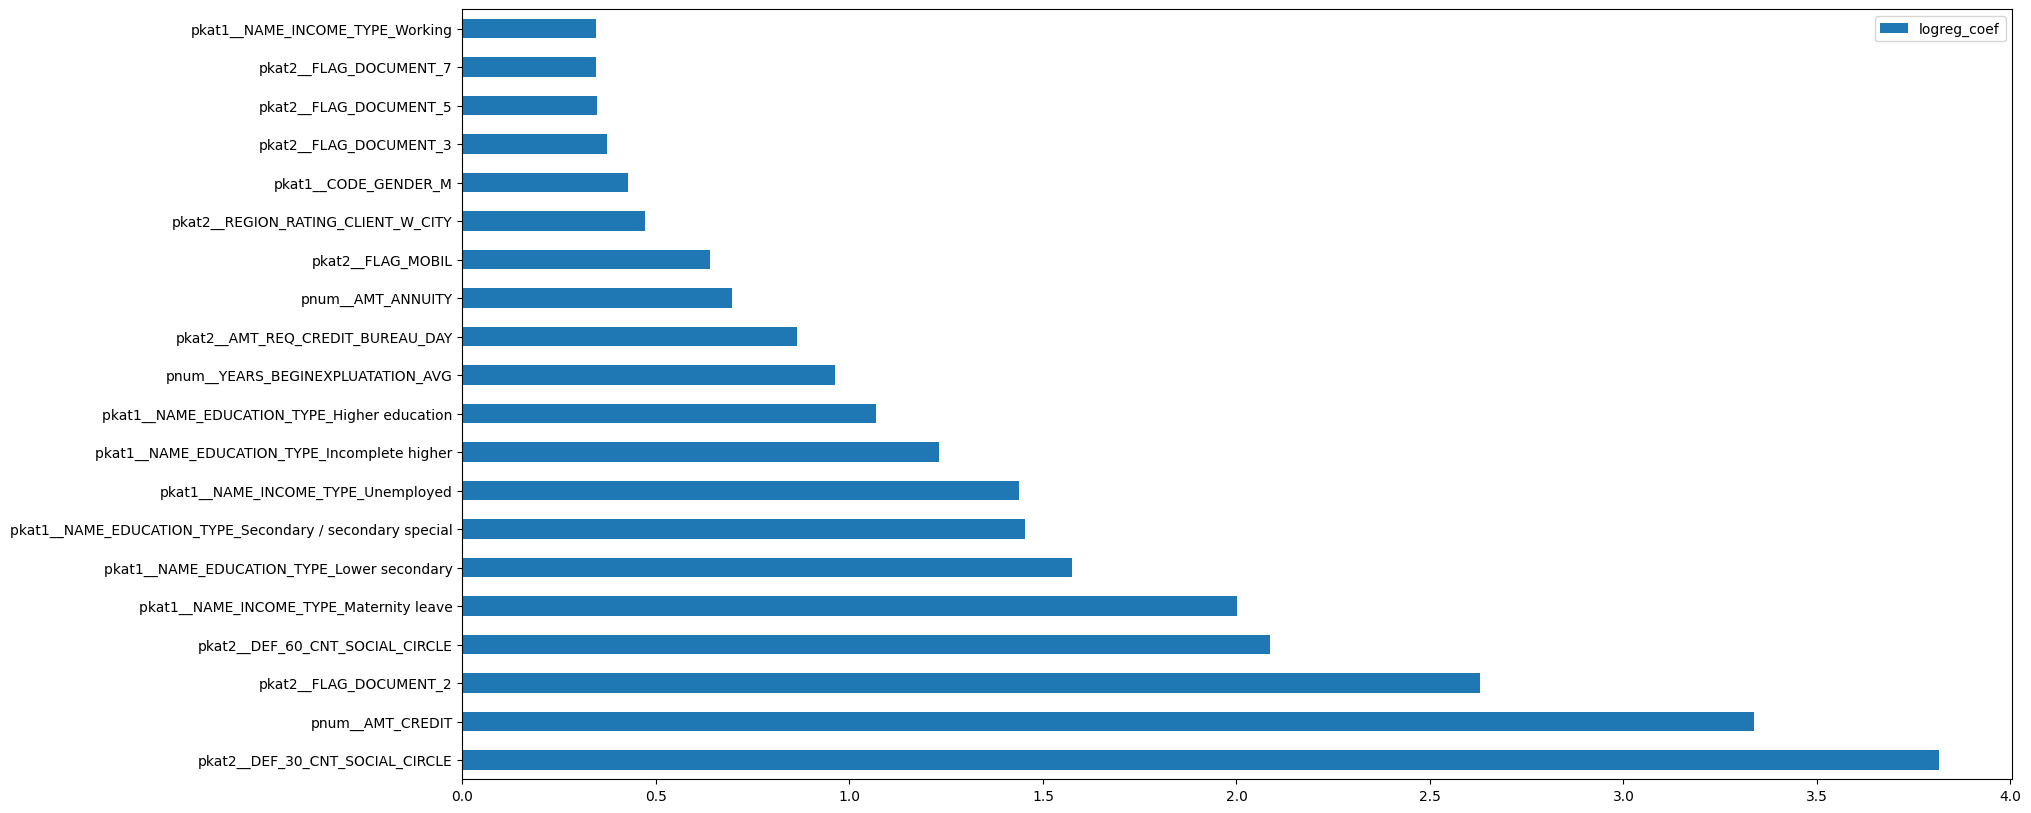

In [86]:
feature_importance_logreg=pd.DataFrame({'important_features':X_train.columns,'logreg_coef':logreg.coef_[0]}, index=X_train.columns).sort_values(by='logreg_coef',ascending=False).nlargest(20, columns='logreg_coef')
feature_importance_logreg.plot(kind='barh', figsize = (20,10))

In [87]:
feature_importance_logreg.index.to_list()

['pkat2__DEF_30_CNT_SOCIAL_CIRCLE',
 'pnum__AMT_CREDIT',
 'pkat2__FLAG_DOCUMENT_2',
 'pkat2__DEF_60_CNT_SOCIAL_CIRCLE',
 'pkat1__NAME_INCOME_TYPE_Maternity leave',
 'pkat1__NAME_EDUCATION_TYPE_Lower secondary',
 'pkat1__NAME_EDUCATION_TYPE_Secondary / secondary special',
 'pkat1__NAME_INCOME_TYPE_Unemployed',
 'pkat1__NAME_EDUCATION_TYPE_Incomplete higher',
 'pkat1__NAME_EDUCATION_TYPE_Higher education',
 'pnum__YEARS_BEGINEXPLUATATION_AVG',
 'pkat2__AMT_REQ_CREDIT_BUREAU_DAY',
 'pnum__AMT_ANNUITY',
 'pkat2__FLAG_MOBIL',
 'pkat2__REGION_RATING_CLIENT_W_CITY',
 'pkat1__CODE_GENDER_M',
 'pkat2__FLAG_DOCUMENT_3',
 'pkat2__FLAG_DOCUMENT_5',
 'pkat2__FLAG_DOCUMENT_7',
 'pkat1__NAME_INCOME_TYPE_Working']

In [88]:
score_auc = cross_val_score(estimator=logreg,X=X_train[feature_importance_logreg.index.to_list()], y=y_train, cv=5, scoring='roc_auc')
print(score_auc)
print(score_auc.mean())

[0.62711281 0.6267523  0.6255039  0.62623853 0.62633607]
0.6263887223613775


**Random Forest Classifier**

In [89]:
rf = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10, n_jobs=-1)

rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, n_jobs=-1, random_state=42)

In [90]:
y_pred = rf.predict(X_test)

In [91]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.70      0.71     56536
           1       0.71      0.73      0.72     56539

    accuracy                           0.72    113075
   macro avg       0.72      0.72      0.72    113075
weighted avg       0.72      0.72      0.72    113075



In [92]:
cm_rf = confusion_matrix(y_test, y_pred)
#print(cm_rf)

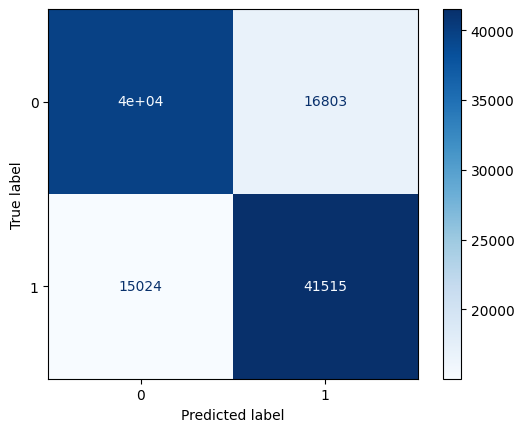

In [93]:
# Melihat confusion matrix dengan ConfusionMatrixDisplay()
vis_cm = ConfusionMatrixDisplay(confusion_matrix = cm_rf,
                                display_labels = rf.classes_)
vis_cm.plot(cmap=plt.cm.Blues);

<Axes: >

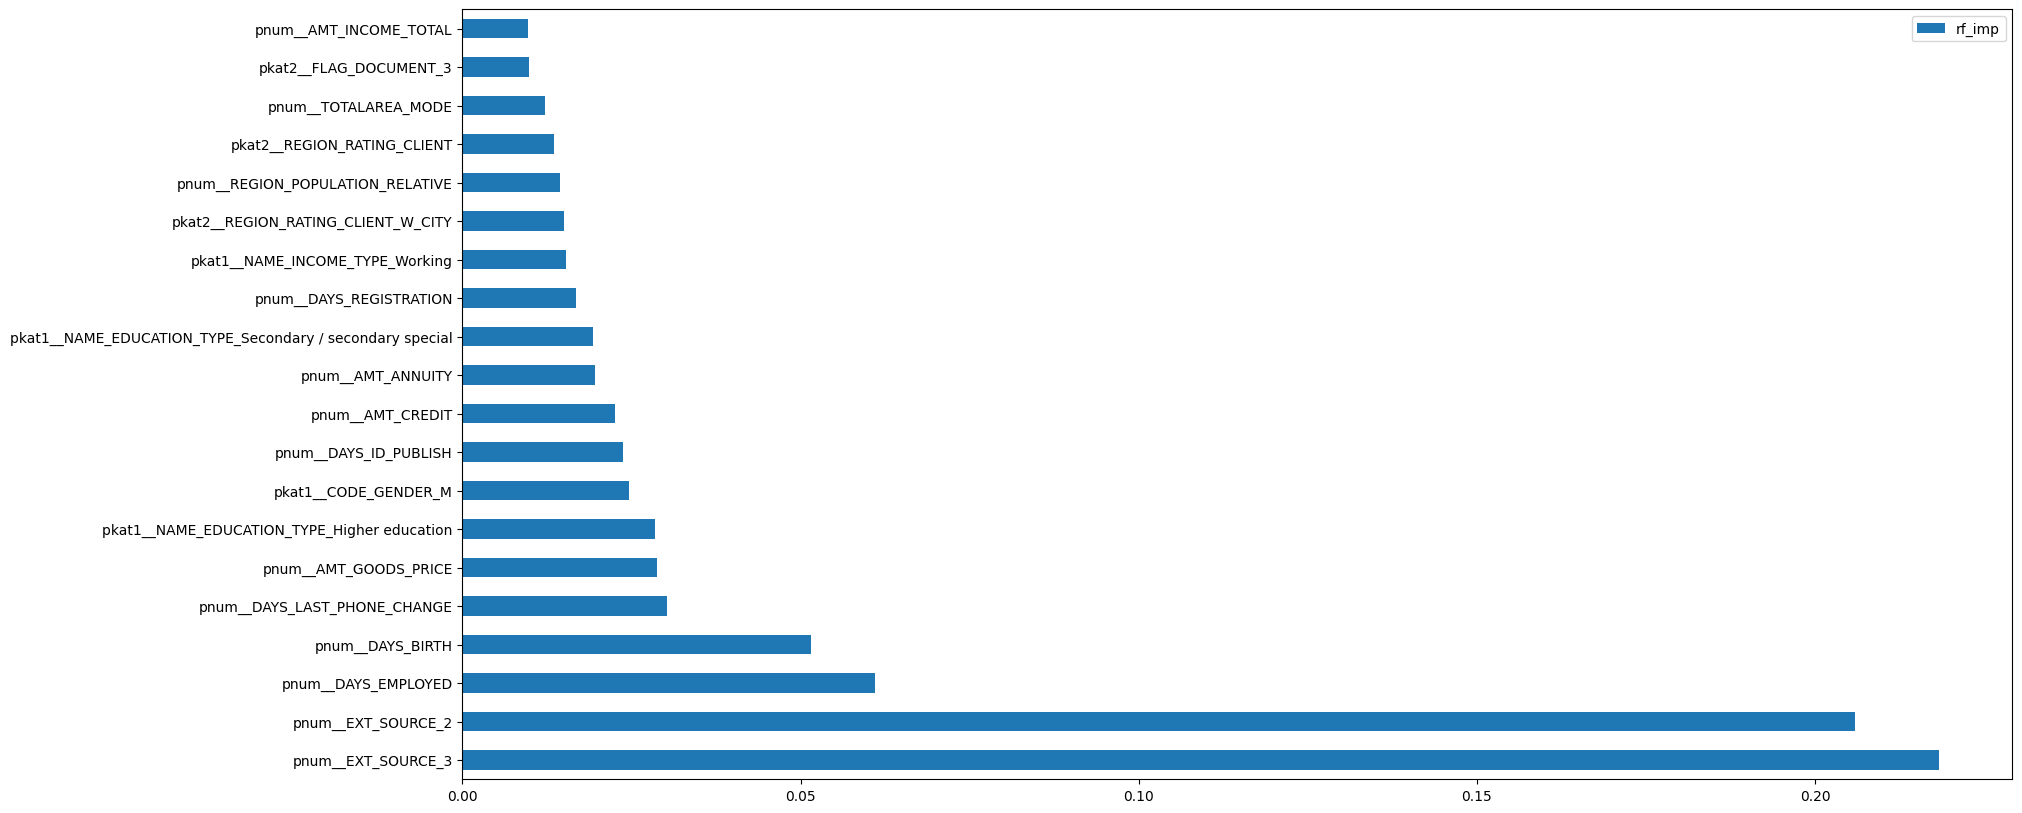

In [94]:
feature_importance_rf=pd.DataFrame({'important_features':X_train.columns,'rf_imp':rf.feature_importances_}, index=X_train.columns).sort_values(by='rf_imp', ascending=False).nlargest(20, columns='rf_imp')
feature_importance_rf.plot(kind='barh', figsize = (20,10))

In [95]:
feature_importance_rf.index.to_list()

['pnum__EXT_SOURCE_3',
 'pnum__EXT_SOURCE_2',
 'pnum__DAYS_EMPLOYED',
 'pnum__DAYS_BIRTH',
 'pnum__DAYS_LAST_PHONE_CHANGE',
 'pnum__AMT_GOODS_PRICE',
 'pkat1__NAME_EDUCATION_TYPE_Higher education',
 'pkat1__CODE_GENDER_M',
 'pnum__DAYS_ID_PUBLISH',
 'pnum__AMT_CREDIT',
 'pnum__AMT_ANNUITY',
 'pkat1__NAME_EDUCATION_TYPE_Secondary / secondary special',
 'pnum__DAYS_REGISTRATION',
 'pkat1__NAME_INCOME_TYPE_Working',
 'pkat2__REGION_RATING_CLIENT_W_CITY',
 'pnum__REGION_POPULATION_RELATIVE',
 'pkat2__REGION_RATING_CLIENT',
 'pnum__TOTALAREA_MODE',
 'pkat2__FLAG_DOCUMENT_3',
 'pnum__AMT_INCOME_TOTAL']

In [96]:
score_auc = cross_val_score(estimator=rf,X=X_train[feature_importance_rf.index.to_list()], y=y_train, cv=5, scoring='roc_auc')
print(score_auc)
print(score_auc.mean())

[0.79183909 0.78987683 0.79322336 0.79291879 0.79229426]
0.792030467773406


**XGBoost**

In [97]:
xgb = XGBClassifier(learning_rate=0.01, n_estimators=100, max_depth=10)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [98]:
y_pred = rf.predict(X_test)

In [99]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.70      0.71     56536
           1       0.71      0.73      0.72     56539

    accuracy                           0.72    113075
   macro avg       0.72      0.72      0.72    113075
weighted avg       0.72      0.72      0.72    113075



In [100]:
cm_xgb = confusion_matrix(y_test, y_pred)
print(cm_xgb)

[[39733 16803]
 [15024 41515]]


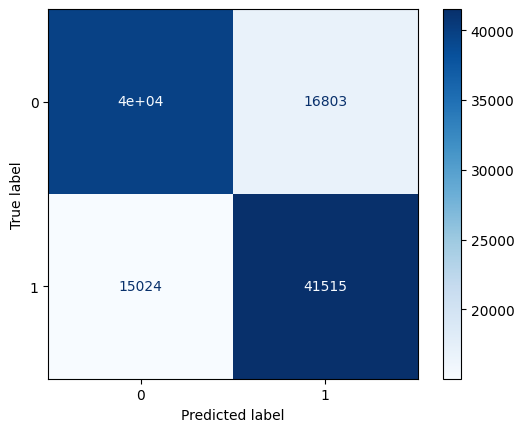

In [101]:
# Melihat confusion matrix dengan ConfusionMatrixDisplay()
vis_cm = ConfusionMatrixDisplay(confusion_matrix = cm_xgb,
                                display_labels = xgb.classes_)
vis_cm.plot(cmap=plt.cm.Blues);

<Axes: >

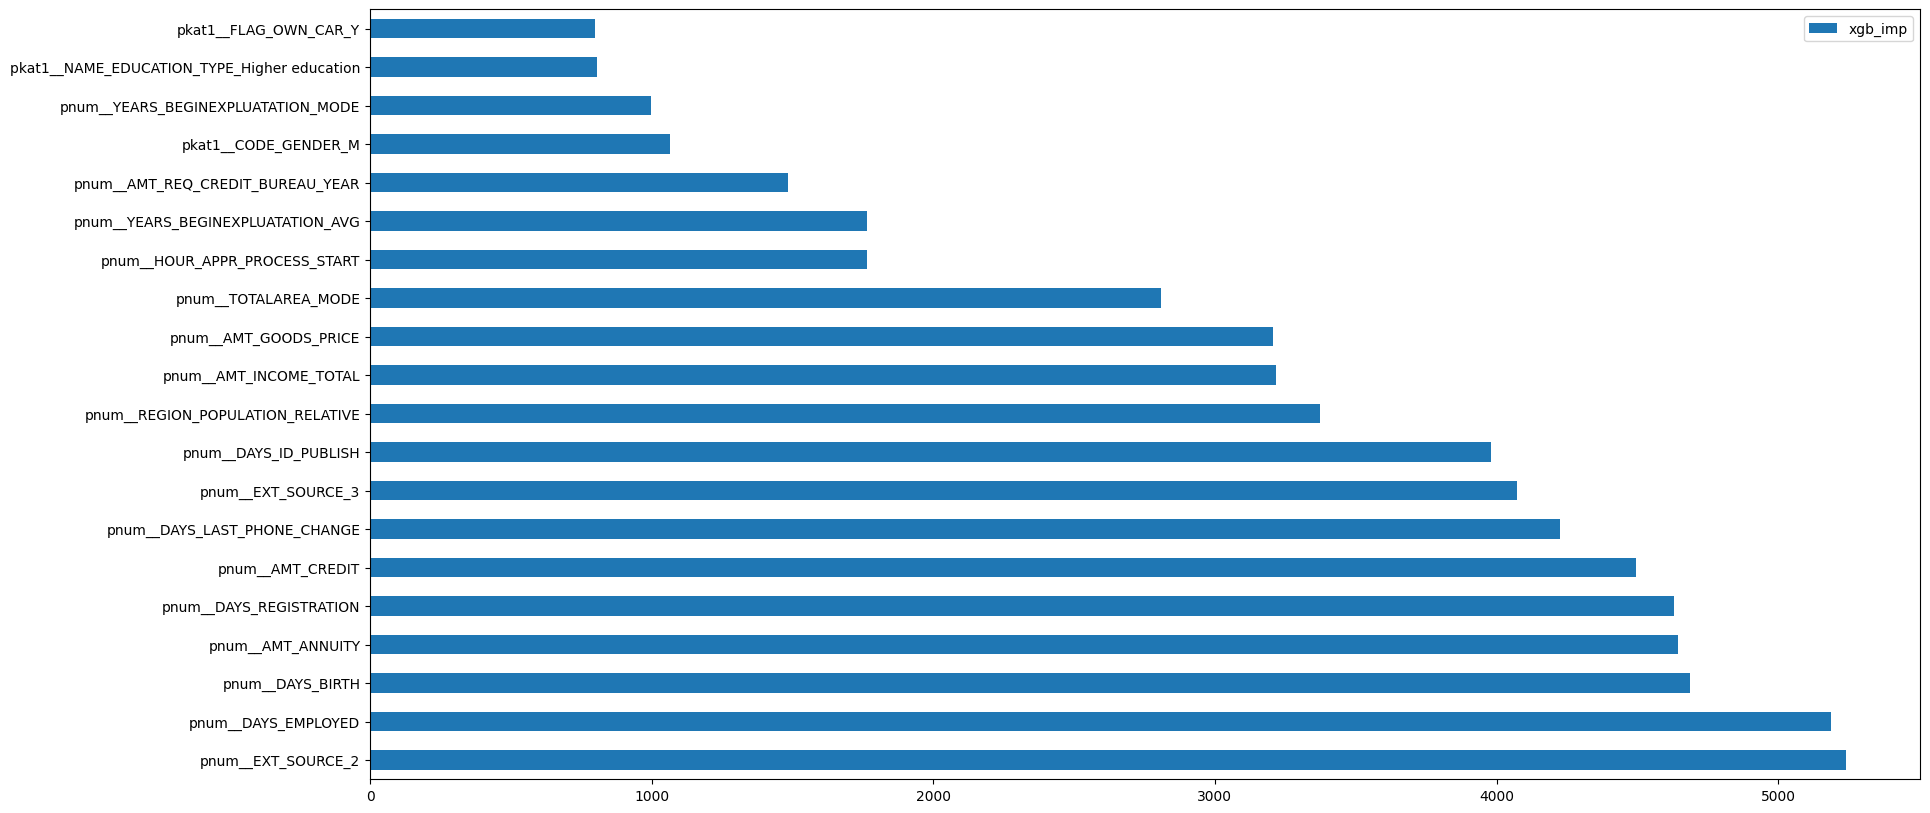

In [102]:
feature_importance_xgb = xgb.get_booster().get_score(importance_type='weight')
keys = list(feature_importance_xgb.keys())
values = list(feature_importance_xgb.values())

top_20_xgb = pd.DataFrame(data=values, index=keys, columns=["xgb_imp"]).sort_values(by = "xgb_imp", ascending=False).nlargest(20, columns="xgb_imp")
top_20_xgb.plot(kind='barh', figsize = (20,10))

In [103]:
list_top_20_xgb=top_20_xgb.index.to_list()
list_top_20_xgb

['pnum__EXT_SOURCE_2',
 'pnum__DAYS_EMPLOYED',
 'pnum__DAYS_BIRTH',
 'pnum__AMT_ANNUITY',
 'pnum__DAYS_REGISTRATION',
 'pnum__AMT_CREDIT',
 'pnum__DAYS_LAST_PHONE_CHANGE',
 'pnum__EXT_SOURCE_3',
 'pnum__DAYS_ID_PUBLISH',
 'pnum__REGION_POPULATION_RELATIVE',
 'pnum__AMT_INCOME_TOTAL',
 'pnum__AMT_GOODS_PRICE',
 'pnum__TOTALAREA_MODE',
 'pnum__HOUR_APPR_PROCESS_START',
 'pnum__YEARS_BEGINEXPLUATATION_AVG',
 'pnum__AMT_REQ_CREDIT_BUREAU_YEAR',
 'pkat1__CODE_GENDER_M',
 'pnum__YEARS_BEGINEXPLUATATION_MODE',
 'pkat1__NAME_EDUCATION_TYPE_Higher education',
 'pkat1__FLAG_OWN_CAR_Y']

In [104]:
score_auc = cross_val_score(estimator=xgb,X=X_train[list_top_20_xgb], y=y_train, cv=5, scoring='roc_auc')
print(score_auc)
print(score_auc.mean())

[0.8154335  0.81385421 0.81593223 0.81436221 0.81464929]
0.8148462877217071


### Prediction

In [105]:
import pickle

In [107]:
pickle.dump(xgb, open('model_xgboost_hci.pkl', 'wb'))

In [108]:
best_model = pickle.load(open('model_xgboost_hci.pkl', 'rb'))

In [109]:
test_new[list_top_20_xgb].head()

,pnum__EXT_SOURCE_2,pnum__DAYS_EMPLOYED,pnum__DAYS_BIRTH,pnum__AMT_ANNUITY,pnum__DAYS_REGISTRATION,pnum__AMT_CREDIT,pnum__DAYS_LAST_PHONE_CHANGE,pnum__EXT_SOURCE_3,pnum__DAYS_ID_PUBLISH,pnum__REGION_POPULATION_RELATIVE,pnum__AMT_INCOME_TOTAL,pnum__AMT_GOODS_PRICE,pnum__TOTALAREA_MODE,pnum__HOUR_APPR_PROCESS_START,pnum__YEARS_BEGINEXPLUATATION_AVG,pnum__AMT_REQ_CREDIT_BUREAU_YEAR,pkat1__CODE_GENDER_M,pnum__YEARS_BEGINEXPLUATATION_MODE,pkat1__NAME_EDUCATION_TYPE_Higher education,pkat1__FLAG_OWN_CAR_Y
0,0.923572,0.133318,0.666573,0.102453,0.217941,0.238037,0.398991,0.180263,0.127914,0.257380,0.024654,0.184049,0.0392,0.782609,0.9732,0.000000,0.0,0.9732,1.0,0.0
1,0.341111,0.255870,0.600661,0.084558,0.384369,0.080785,0.000000,0.490287,0.255671,0.491855,0.016440,0.061350,0.0707,0.391304,0.9816,0.176471,1.0,0.9816,0.0,0.0
2,0.818463,0.255240,0.711206,0.378515,0.091687,0.280965,0.196285,0.692134,0.551827,0.260854,0.040054,0.265849,0.0707,0.608696,0.9816,0.235294,1.0,0.9816,1.0,1.0
3,0.596110,0.106803,0.371731,0.262078,0.084310,0.695297,0.413896,0.694076,0.662886,0.361760,0.065721,0.695297,0.3700,0.478261,0.9970,0.176471,0.0,0.9970,0.0,0.0
4,0.497875,0.125415,0.319315,0.166995,0.168620,0.263804,0.188260,0.587946,0.671393,0.135340,0.034920,0.263804,0.0707,0.217391,0.9816,0.117647,1.0,0.9816,0.0,1.0


In [110]:
# Re-align test data columns to match training data
test_data_corrected = test_new[list_top_20_xgb].reindex(columns=X_train.columns, fill_value=0)  # Align columns
#dtest_corrected = xgb.DMatrix(test_data_corrected)

# Prediction should now work without errors
try:
    prediksi = best_model.predict(test_data_corrected)
except ValueError as e:
    print("Error:", e)

In [111]:
test_new.insert(0, "PRED_TARGET", prediksi, True)
test_new.head(10)

,PRED_TARGET,pnum__CNT_CHILDREN,pnum__AMT_INCOME_TOTAL,pnum__AMT_CREDIT,pnum__AMT_ANNUITY,pnum__AMT_GOODS_PRICE,pnum__REGION_POPULATION_RELATIVE,pnum__DAYS_BIRTH,pnum__DAYS_EMPLOYED,pnum__DAYS_REGISTRATION,...,pkat2__FLAG_DOCUMENT_15,pkat2__FLAG_DOCUMENT_16,pkat2__FLAG_DOCUMENT_17,pkat2__FLAG_DOCUMENT_18,pkat2__FLAG_DOCUMENT_19,pkat2__FLAG_DOCUMENT_20,pkat2__FLAG_DOCUMENT_21,pkat2__AMT_REQ_CREDIT_BUREAU_HOUR,pkat2__AMT_REQ_CREDIT_BUREAU_DAY,pkat2__AMT_REQ_CREDIT_BUREAU_WEEK
0,0,0.00,0.024654,0.238037,0.102453,0.184049,0.257380,0.666573,0.133318,0.217941,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0.00,0.016440,0.080785,0.084558,0.061350,0.491855,0.600661,0.255870,0.384369,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0.00,0.040054,0.280965,0.378515,0.265849,0.260854,0.711206,0.255240,0.091687,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0.10,0.065721,0.695297,0.262078,0.695297,0.361760,0.371731,0.106803,0.084310,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0.05,0.034920,0.263804,0.166995,0.263804,0.135340,0.319315,0.125415,0.168620,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0,0.00,0.055454,0.415673,0.181206,0.347648,0.344765,0.630901,0.687665,0.257820,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0,0.10,0.034920,0.206417,0.111187,0.149284,0.312048,0.523436,0.147692,0.426819,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0,0.00,0.031840,0.061350,0.066889,0.061350,0.067691,0.121969,0.079372,0.213431,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0,0.00,0.065721,0.145374,0.149553,0.122699,0.636177,0.302738,0.057954,0.071073,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0,0.05,0.030814,0.000000,0.017063,0.000000,0.254391,0.171193,0.150269,0.342467,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [112]:
# Merubah dalam format DataFrame
hasil_prediksi=pd.concat([_test,test_new],axis=1)
hasil_prediksi.head(10)

,SK_ID_CURR,PRED_TARGET,pnum__CNT_CHILDREN,pnum__AMT_INCOME_TOTAL,pnum__AMT_CREDIT,pnum__AMT_ANNUITY,pnum__AMT_GOODS_PRICE,pnum__REGION_POPULATION_RELATIVE,pnum__DAYS_BIRTH,pnum__DAYS_EMPLOYED,...,pkat2__FLAG_DOCUMENT_15,pkat2__FLAG_DOCUMENT_16,pkat2__FLAG_DOCUMENT_17,pkat2__FLAG_DOCUMENT_18,pkat2__FLAG_DOCUMENT_19,pkat2__FLAG_DOCUMENT_20,pkat2__FLAG_DOCUMENT_21,pkat2__AMT_REQ_CREDIT_BUREAU_HOUR,pkat2__AMT_REQ_CREDIT_BUREAU_DAY,pkat2__AMT_REQ_CREDIT_BUREAU_WEEK
0,100001,0,0.00,0.024654,0.238037,0.102453,0.184049,0.257380,0.666573,0.133318,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,0,0.00,0.016440,0.080785,0.084558,0.061350,0.491855,0.600661,0.255870,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100013,0,0.00,0.040054,0.280965,0.378515,0.265849,0.260854,0.711206,0.255240,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100028,0,0.10,0.065721,0.695297,0.262078,0.695297,0.361760,0.371731,0.106803,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,100038,0,0.05,0.034920,0.263804,0.166995,0.263804,0.135340,0.319315,0.125415,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,100042,0,0.00,0.055454,0.415673,0.181206,0.347648,0.344765,0.630901,0.687665,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,100057,0,0.10,0.034920,0.206417,0.111187,0.149284,0.312048,0.523436,0.147692,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,100065,0,0.00,0.031840,0.061350,0.066889,0.061350,0.067691,0.121969,0.079372,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,100066,0,0.00,0.065721,0.145374,0.149553,0.122699,0.636177,0.302738,0.057954,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,100067,0,0.05,0.030814,0.000000,0.017063,0.000000,0.254391,0.171193,0.150269,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [113]:
hasil_prediksi['PRED_TARGET'].value_counts()

PRED_TARGET
0    42906
1     5838
Name: count, dtype: int64

In [114]:
hasil_prediksi.to_csv('prediksi_xgboost_hci.csv')